In [31]:
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
transforms = transforms.Compose([
	transforms.ToTensor(), 
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_data = CIFAR10(root='./data', train=True, download=True, transform=transforms)
test_data = CIFAR10(root='./data', train=False, download=True, transform=transforms)

# Make validation set
split_size = int(len(train_data) * 0.8)
train_data, val_data = random_split(train_data, [split_size, len(train_data) - split_size])

BATCH_SIZE = 20

# Dataloaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

classes = ['airplane', 'automobile', 'bird', 'cat', 
		   'deer', 'dog', 'frog', 'horse', 'ship', 
		   'truck']

Files already downloaded and verified
Files already downloaded and verified


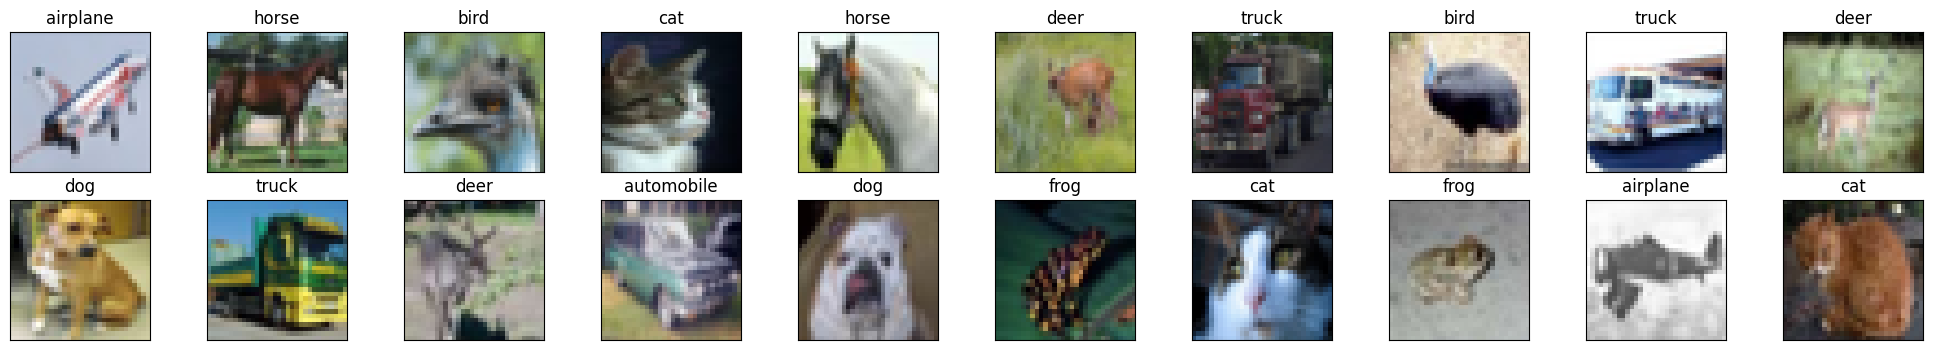

In [49]:
import matplotlib.pyplot as plt
import torchvision

# Visualize some images
def imshow(img):
	img = img / 2 + 0.5
	npimg = img.numpy()
	plt.imshow(np.transpose(npimg, (1, 2, 0)))
	# plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
# images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
	ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
	ax.set_title(classes[labels[idx]])
	imshow(images[idx])

plt.show()